In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

%matplotlib inline

# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# generate a 784 element mask with a square, with side
# length (sideLength), zero'd out of the middle
def generateCenterSquareMask(sideLength):
    mask = np.ones((28, 28))
    leftIdx = (28 - sideLength)/2
    rightIdx = (28 + sideLength)/2
    mask[leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 1])[1]
    y_idx = np.where([vectorMask == 0])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# let's get the data for halves
def returnHalfData(ncols):
    train, test = returnData()

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    '''
    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)
    '''

    train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(ncols))
    test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(ncols))

    return train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight

# let's get the data for halves
def returnSquareData(squareSideLength):
    train, test = returnData()

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    '''
    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)
    '''
    
    train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle = hideData(train, generateCenterSquareMask(squareSideLength))
    test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle = hideData(test, generateCenterSquareMask(squareSideLength))

    return train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle, test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle

# let's get the data
def returnData():
    train = np.copy(mnist.train.images.T)
    test = np.copy(mnist.test.images.T)

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    for i in range(n_train):
        img = unpackrw(train[:, i], 28, 28)
        train[:, i] = packcw(img, 28, 28)
    for i in range(n_test):
        img = unpackrw(test[:, i], 28, 28)
        test[:, i] = packcw(img, 28, 28)

    return train, test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
train, test = returnData()
size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

----MNIST dataset loaded----
Train data: 784 x 55000
Test data: 784 x 10000


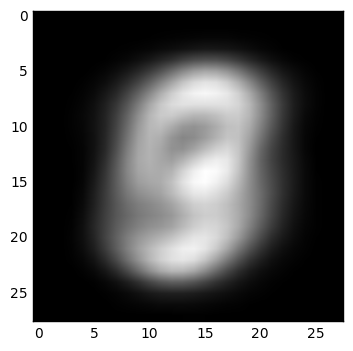

In [6]:
avg_image = (np.mean(train, axis=1))
img = unpackcw(avg_image, 28, 28)
plt.imshow(img,cmap='gray')    

In [26]:
meanOfColumns = np.zeros((55000, 28))
for i in range(n_train):
    for col in range(28):
        meanOfColumns[i, col] = np.mean(train[(28-col-1)*28:(28-col)*28, i])

In [27]:
meanColumns = np.zeros(28)
stdDevColumns = np.zeros(28)

for i in range(28):
    meanColumns[i] = np.mean(meanOfColumns[:, i])
    stdDevColumns[i] = np.std(meanOfColumns[:, i])

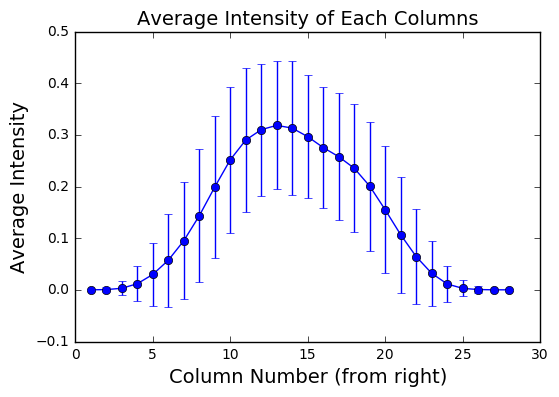

In [30]:
fig, ax = plt.subplots()
plt.figure(1)

numColsIdxs = np.arange(1,29)

plt.plot(numColsIdxs, meanColumns, '-o', c='b')
plt.errorbar(numColsIdxs, meanColumns, yerr=stdDevColumns, linestyle='', c='b')

plt.title("Average Intensity of Each Columns", fontsize=14)
plt.ylabel("Average Intensity", fontsize=14)
plt.xlabel("Column Number (from right)", fontsize=14)


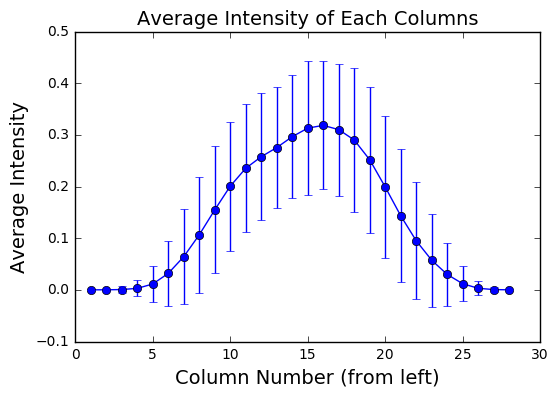

In [31]:
meanColumns_fromLeft = np.fliplr([meanColumns])[0]
stdDevColumns_fromLeft = np.fliplr([stdDevColumns])[0]

fig, ax = plt.subplots()
plt.figure(1)

numColsIdxs = np.arange(1,29)

plt.plot(numColsIdxs, meanColumns_fromLeft, '-o', c='b')
plt.errorbar(numColsIdxs, meanColumns_fromLeft, yerr=stdDevColumns_fromLeft, linestyle='', c='b')

plt.title("Average Intensity of Each Columns", fontsize=14)
plt.ylabel("Average Intensity", fontsize=14)
plt.xlabel("Column Number (from left)", fontsize=14)
